In [2]:
import numpy as np
import itertools

In [3]:
def get_shapes(any_):
    for array in any_:
        try:
            print(array.shape)
        except:
            print("NONE")
    print("\n")

In [4]:
# ============= ACTIVATION FUNCTIONS ===============#

def sigmoid(Z, prime=False):
    # np.
    if prime:
        return sigmoid(Z) * (1 - sigmoid(Z))
    return 1 / (1 + np.exp(-Z))


def linear(Z, prime=False):
    if prime:
        return np.ones_like(Z)
    return Z


def relu(Z, alpha=0, prime=False):
    if prime:
        Z_relu = np.ones_like(Z, dtype=np.float64)
        Z_relu[Z < 0] = alpha
        return Z_relu
    return np.where(Z < 0, alpha * Z, Z)


def tanh(Z, prime=False):
    # np.tanh() could be used directly to speed this up
    if prime:
        return 1 - np.power(tanh(Z), 2)
    return (2 / (1 + np.exp(-2 * Z))) - 1


def elu(Z, prime=False):
    # https://mlfromscratch.com/activation-functions-explained/#/
    alpha = 0.2
    if prime:
        return np.where(Z < 0, alpha * (np.exp(Z)),1)
    return np.where(Z < 0, alpha * (np.exp(Z) - 1), Z)


def softmax(Z, prime=False):
    if prime:
        return 1
    return np.exp(Z) / np.sum(np.exp(Z),axis=0)

In [5]:
# ============== LOSS FUNCTIONS ===============#

def calculate_error(Y, Y_hat):
    m = Y.shape[1]
    return np.sum(0.5 * np.square(Y - Y_hat)) / m

In [6]:
class NeuralNetwork:
    

    def __init__(
        self,
        input_layer: tuple,
        hidden_layer: list, # list of tuples
        output_layer: int,
        alpha: float,
        no_of_iterations: int,
    ):
        self.input_layer = input_layer
        self.hidden_layer = hidden_layer
        self.output_layer = output_layer
        self.alpha = alpha
        self.no_of_iterations = no_of_iterations
        
        self.m = X.shape[1] # where (no_of_features, no_of_training_examples)
        self.layers = len(self.weight_set_dimensions) + 1


    def calculate_delta_final(self, Y):
        final_act_func = self.activation_functions[-1]
        arg_to_pass_to_eval = "(self.Z[-1], prime=True)"
        
        return (self.A[-1] - Y) * eval(final_act_func + arg_to_pass_to_eval)


    def get_dimensions_and_activations(self):
        self.dimensions = []
        self.activation_functions = []
        
        self.dimensions.append(self.input_layer[0])
        self.activation_functions.append(self.input_layer[1])

        for dim, act_func in self.hidden_layer:
            self.dimensions.append(dim)
            self.activation_functions.append(act_func)

        self.dimensions.append(self.output_layer)

        
    @property
    def weight_set_dimensions(self):
        self.get_dimensions_and_activations()
        a, b = itertools.tee(self.dimensions[::-1])
        next(b, None)
        weight_set_dimensions = list(zip(a, b))[::-1]
        return weight_set_dimensions


    def initialise_weights(self):

        self.W = np.empty_like(range(self.layers), dtype=object)
        self.B = np.empty_like(range(self.layers), dtype=object)
        self.W[0] = None
        self.B[0] = None
        for layer, (y, x) in zip(range(1, self.layers), self.weight_set_dimensions):
            np.random.seed(42)
            self.W[layer] = np.random.rand(y, x)
            self.B[layer] = np.random.rand(y, 1)


    def forwardpass(self, X):
        self.Z = np.empty_like(range(self.layers), dtype=object)
        self.A = np.empty_like(range(self.layers), dtype=object)
        self.A[0] = X
        self.Z[0] = None
        for layer in range(1, self.layers):
            # activation_function starts from 0 whereas layer starts from 1
            active_function = self.activation_functions[layer - 1]
            arg_to_pass_to_eval = "(self.Z[layer])"

            self.Z[layer] = self.W[layer] @ self.A[layer - 1] + self.B[layer]
            self.A[layer] = eval(active_function + arg_to_pass_to_eval)


    def backpropagation(self, Y):
        delta_final = self.calculate_delta_final(Y)
        self.delta = np.empty_like(range(self.layers), dtype=object)
        self.delta[0] = None
        self.delta[-1] = delta_final

        self.gradient_W = np.empty_like(range(self.layers), dtype=object)
        self.gradient_B = np.empty_like(range(self.layers), dtype=object)
        self.gradient_W[0] = None
        self.gradient_B[0] = None
        
        # We substract 1 here as delta_final is calculated seperately above
        for layer in reversed(range(1, self.layers - 1)):
            active_function = self.activation_functions[layer - 1]
            arg_to_pass_to_eval = "(self.Z[layer], prime=True)"

            self.delta[layer] = (
                self.W[layer + 1].T @ self.delta[layer + 1] *
                eval(active_function + arg_to_pass_to_eval)
            )

        # calculate the gradient
        for layer in range(1, self.layers):
            self.gradient_W[layer] = (self.delta[layer] @ self.A[layer - 1].T) / self.m
            self.gradient_B[layer] = np.sum(self.delta[layer], axis=1, keepdims=True) / self.m

        #update the weights
        for layer in range(1, self.layers):
            self.W[layer] -= self.alpha * self.gradient_W[layer]
            self.B[layer] -= self.alpha * self.gradient_B[layer]
            
            
    def fit(self, X, Y):
        self.initialise_weights()
        
        for iteration in range(self.no_of_iterations + 1):
            self.forwardpass(X)
            self.backpropagation(Y)
            if iteration % 2500 == 0 or iteration == self.no_of_iterations:
                print("iteration %s - loss %.20f" %(iteration, calculate_error(Y, self.A[-1])))


    def predict(self, X):
        self.forwardpass(X)

        return np.argmax(self.A[-1].T, axis=1)

# Testing with benchmark datasets

## 1.Iris Dataset

In [29]:
from sklearn.datasets import load_iris
data = load_iris()
X = data.data[:,[0,2]].T
y = data.target
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y = lb.fit_transform(y)
Y = Y.T

In [30]:
print(X.shape)
print(Y.shape)

(2, 150)
(3, 150)


In [31]:
self = NeuralNetwork(
    input_layer=(2, "tanh"),
    hidden_layer=[(6, "tanh"),(4, "sigmoid")],
    output_layer=3,
    alpha=0.5,
    no_of_iterations=50000
)

self.fit(X, Y)

iteration 0 - loss 0.82169033162196303266
iteration 2500 - loss 0.16251929502847412001
iteration 5000 - loss 0.05813389861482723409
iteration 7500 - loss 0.04259455423665022694
iteration 10000 - loss 0.04317642777636402501
iteration 12500 - loss 0.03964681427312898715
iteration 15000 - loss 0.03814975527268266858
iteration 17500 - loss 0.03026024003012266900
iteration 20000 - loss 0.02722562465209393476
iteration 22500 - loss 0.02566105009387717809
iteration 25000 - loss 0.02478120589585058528
iteration 27500 - loss 0.02424692500633551448
iteration 30000 - loss 0.02392585588467597071
iteration 32500 - loss 0.02372011960418082127
iteration 35000 - loss 0.02336982031108942107
iteration 37500 - loss 0.02240300576451696030
iteration 40000 - loss 0.02233380323133155390
iteration 42500 - loss 0.02229624376873709860
iteration 45000 - loss 0.02226452709394543400
iteration 47500 - loss 0.02223336195770346524
iteration 50000 - loss 0.02220126565096572357


In [32]:
self.predict(X) == np.argmax(Y, axis=0)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
       False,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

Text(0, 0.5, 'petal length')

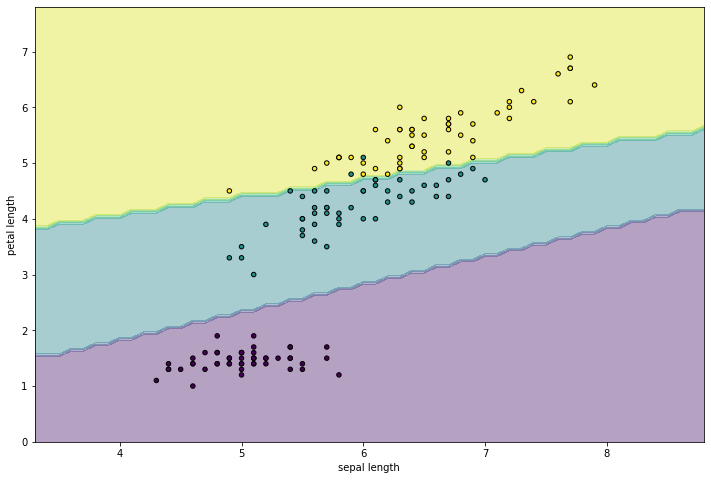

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
dt = data.data[:,[0,2]]
x_min, x_max = dt[:, 0].min() - 1, dt[:, 0].max() + 1
y_min, y_max = dt[:, 1].min() - 1, dt[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# here "model" is your model's prediction (classification) function
Z = self.predict(np.c_[xx.ravel(), yy.ravel()].T) 

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z,alpha=0.4)
#plt.axis('off')
plt.scatter(dt[:, 0], dt[:, 1], c=y,s=20, edgecolor='k')
plt.xlabel('sepal length')
plt.ylabel('petal length')

## 2.Make Moons dataset

In [34]:
from sklearn.datasets import make_moons
from sklearn import preprocessing

x,y =make_moons(n_samples=1500, noise=.05)
X = x.T
lb = preprocessing.LabelBinarizer()
Y = lb.fit_transform(y)
y_next = np.where(y==0,1,0)
Y = Y.T
Y = list(Y)
Y.append(y_next)
Y = np.array(Y)

print(X.shape)
print(Y.shape)

(2, 1500)
(2, 1500)


In [21]:
model = NeuralNetwork(
    input_layer=(2, "tanh"),
    hidden_layer=[(6, "tanh"),(4, "sigmoid")],
    output_layer=2,
    alpha=0.5,
    no_of_iterations=50000
)

model.fit(X, Y)

iteration 0 - loss 0.41859298339753869822
iteration 2500 - loss 0.00070305342148048163
iteration 5000 - loss 0.00025562841614223573
iteration 7500 - loss 0.00015344423810535428
iteration 10000 - loss 0.00010912917168344004
iteration 12500 - loss 0.00008453153182211218
iteration 15000 - loss 0.00006892962520291013
iteration 17500 - loss 0.00005816660922129829
iteration 20000 - loss 0.00005029980131882376
iteration 22500 - loss 0.00004430171760505275
iteration 25000 - loss 0.00003957864147095562
iteration 27500 - loss 0.00003576386778066482
iteration 30000 - loss 0.00003261880200643014
iteration 32500 - loss 0.00002998157273335145
iteration 35000 - loss 0.00002773852034287663
iteration 37500 - loss 0.00002580750964836980
iteration 40000 - loss 0.00002412771937624505
iteration 42500 - loss 0.00002265315574059899
iteration 45000 - loss 0.00002134839721980892
iteration 47500 - loss 0.00002018572420690926
iteration 50000 - loss 0.00001914313505382901


Text(0.5, 1.0, 'Decision Boundaries')

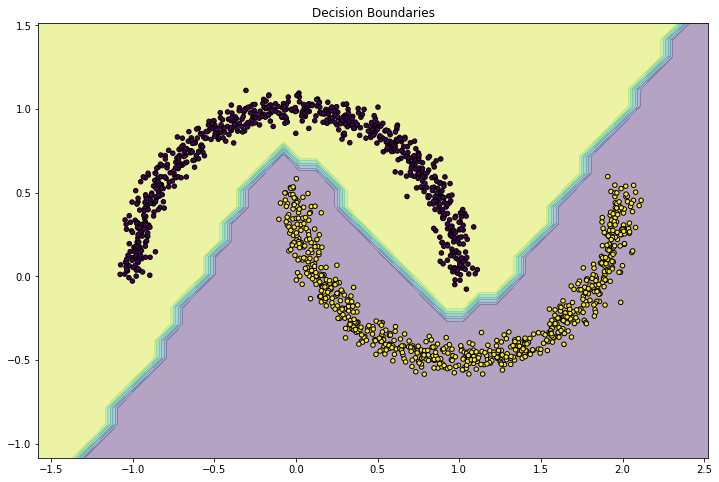

In [28]:
### Decision Boundaries
%matplotlib inline
import matplotlib.pyplot as plt
dt = x
x_min, x_max = dt[:, 0].min() - 0.5, dt[:, 0].max() + 0.5
y_min, y_max = dt[:, 1].min() - 0.5, dt[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# here "model" is your model's prediction (classification) function
Z = model.predict(np.c_[xx.ravel(), yy.ravel()].T) 

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z,alpha=0.4)
#plt.axis('off')
plt.scatter(dt[:, 0], dt[:, 1], c=y,s=20, edgecolor='k')
plt.title('Decision Boundaries')

In [41]:
model.B[3]

array([[-0.14451222],
       [ 0.30291785]])

## 3.Andrew NG Assignment 2 Dataset

In [123]:
ex2data2 = np.loadtxt("/home/cagri/Desktop/Google Drive/data/ex2data2.txt", delimiter=",")

X = ex2data2[:, :-1]
y = ex2data2[:, -1].reshape(-1, 1)

dt = np.c_[X, y]

X = X.T
Y = y.T

In [124]:
model = NeuralNetwork(
    input_layer=(2, "tanh"),
    hidden_layer=[(4, "tanh"), (4, "sigmoid")],
    output_layer=2,
    alpha=0.5,
    no_of_iterations=150000
)

model.fit(X, Y)

iteration 0 - loss 0.41191455319497538579
iteration 2500 - loss 0.18629429694041974019
iteration 5000 - loss 0.18281370603389024421
iteration 7500 - loss 0.18013830445566519911
iteration 10000 - loss 0.17617826927681012883
iteration 12500 - loss 0.17046354062534219143
iteration 15000 - loss 0.16659479418660400052
iteration 17500 - loss 0.16474804076459273472
iteration 20000 - loss 0.16378214449560746235
iteration 22500 - loss 0.16318643627065840263
iteration 25000 - loss 0.16278345933290305769
iteration 27500 - loss 0.16249489954395762714
iteration 30000 - loss 0.16227952707118531439
iteration 32500 - loss 0.16211334406387409302
iteration 35000 - loss 0.16198147602240103859
iteration 37500 - loss 0.16187427064009748956
iteration 40000 - loss 0.16178522184943350259
iteration 42500 - loss 0.16170978565796184645
iteration 45000 - loss 0.16164466479159317336
iteration 47500 - loss 0.16158734692155848900
iteration 50000 - loss 0.16153576960525437012
iteration 52500 - loss 0.1614880092811400

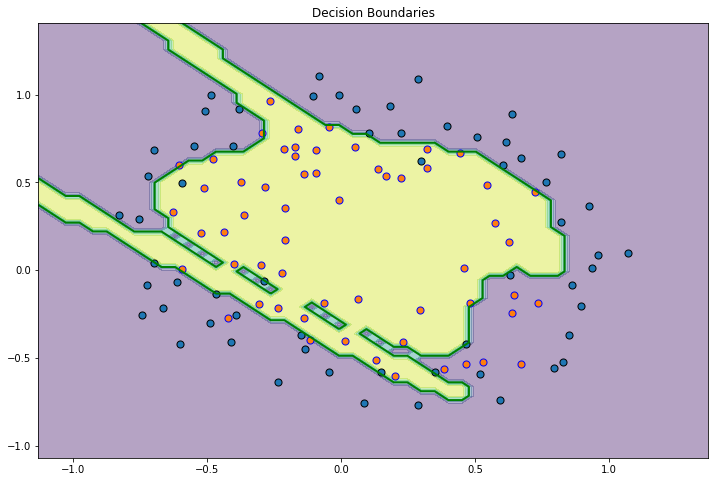

In [125]:
### Decision Boundaries
%matplotlib inline
import matplotlib.pyplot as plt
X = ex2data2

x1_min, x1_max = X[:, 0].min() - 0.3, X[:, 0].max() + 0.3,
x2_min, x2_max = X[:, 1].min() - 0.3, X[:, 1].max() + 0.3,
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))

# here "model" is your model's prediction (classification) function
Z = model.predict(np.c_[xx1.ravel(), xx2.ravel()].T) 

negatives = ex2data2[ex2data2[:, -1] == 0]
positives = ex2data2[ex2data2[:, -1] == 1]

# Put the result into a color plot
Z = Z.reshape(xx1.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx1, xx2, Z,alpha=0.4)
#plt.axis('off')
plt.scatter(negatives[:, 0], negatives[:, 1],s=50, edgecolor='k')
plt.scatter(positives[:, 0], positives[:, 1],s=50, edgecolor='b')
plt.title('Decision Boundaries')

plt.contour(xx1, xx2, Z, [0.5], linewidths=2, colors="g")

In [12]:
class NeuralNetwork:
    

    def __init__(
        self,
        input_layer: tuple,
        hidden_layer: list, # list of tuples
        output_layer: int,
        alpha: float,
        no_of_iterations: int,
    ):
        self.input_layer = input_layer
        self.hidden_layer = hidden_layer
        self.output_layer = output_layer
        self.alpha = alpha
        self.no_of_iterations = no_of_iterations
        
        self.m = X.shape[1] # where (no_of_features, no_of_training_examples)
        self.layers = len(self.weight_set_dimensions)


    def calculate_delta_final(self, Y):
        final_act_func = self.activation_functions[-1]
        arg_to_pass_to_eval = "(self.Z[-1], prime=True)"
        
        return (self.A[-1] - Y) * eval(final_act_func + arg_to_pass_to_eval)


    def get_dimensions_and_activations(self):
        self.dimensions = []
        self.activation_functions = []
        
        self.dimensions.append(self.input_layer[0])
        self.activation_functions.append(self.input_layer[1])

        for dim, act_func in self.hidden_layer:
            self.dimensions.append(dim)
            self.activation_functions.append(act_func)

        self.dimensions.append(self.output_layer)

        
    @property
    def weight_set_dimensions(self):
        self.get_dimensions_and_activations()
        a, b = itertools.tee(self.dimensions[::-1])
        next(b, None)
        weight_set_dimensions = list(zip(a, b))[::-1]
        return weight_set_dimensions


    def initialise_weights(self):

        self.W = np.empty_like(range(self.layers + 1), dtype=object)
        self.B = np.empty_like(range(self.layers + 1), dtype=object)
        self.W[0] = None
        self.B[0] = None
        # self.parameters = {}
        for layer, (y, x) in zip(range(self.layers), self.weight_set_dimensions):
            np.random.seed(42)
            self.W[layer + 1] = np.random.rand(y, x)
            self.B[layer + 1] = np.random.rand(y, 1)
#             self.parameters["W" + str(layer)] = np.random.rand(row, column)
#             self.parameters["B" + str(layer)] = np.random.rand(row, 1)


    def forwardpass(self, X):
#         self._params = {}
#         self._params["A0"] = X
        self.Z = np.empty_like(range(self.layers + 1), dtype=object)
        self.A = np.empty_like(range(self.layers + 1), dtype=object)
        self.A[0] = X
        self.Z[0] = None
        for layer in range(self.layers):
            # activation_function starts from 0 whereas layer starts from 1
            active_function = self.activation_functions[layer]
            arg_to_pass_to_eval = "(self.Z[layer + 1])"

            self.Z[layer + 1] = self.W[layer + 1] @ self.A[layer] + self.B[layer + 1]
            self.A[layer + 1] = eval(active_function + arg_to_pass_to_eval)

#             arg_to_pass_to_eval = "(self._params['Z' + str(layer)])"
#             self._params["Z" + str(layer)] = (self.parameters["W" + str(layer)] @
#                                               self._params["A" + str(layer - 1)] +
#                                               self.parameters["B" + str(layer)])
#             self._params["A" + str(layer)] = eval(active_function + arg_to_pass_to_eval)

    def backpropagation(self, Y):
        delta_final = self.calculate_delta_final(Y)
        self.delta = np.empty_like(range(self.layers + 1), dtype=object)
        self.delta[0] = None
        self.delta[-1] = delta_final

        self.gradient_W = np.empty_like(range(self.layers + 1), dtype=object)
        self.gradient_B = np.empty_like(range(self.layers + 1), dtype=object)
        self.gradient_W[0] = None
        self.gradient_B[0] = None

        # here Z[index+1] is passed instead of Z[index] this is because Z[0] is none.
        # So Z[index+1] is effectively Z[index].

        for layer in reversed(range(1, self.layers)):
            active_function = self.activation_functions[layer]
            arg_to_pass_to_eval = "(self.Z[layer], prime=True)"

            self.delta[layer] = (
                self.W[layer + 1].T @ self.delta[layer + 1] *
                eval(active_function + arg_to_pass_to_eval)
            )

        # calculate the gradient
        for layer in range(self.layers):
            self.gradient_W[layer + 1] = (self.delta[layer + 1] @ self.A[layer].T) / self.m
            self.gradient_B[layer + 1] = np.sum(self.delta[layer + 1], axis=1, keepdims=True) / self.m

        #update the weights
        for layer in range(self.layers):
            self.W[layer+1] -= self.alpha * self.gradient_W[layer+1]
            self.B[layer+1] -= self.alpha * self.gradient_B[layer+1]
            
            
    def fit(self, X, Y):
        self.initialise_weights()
        
        for iteration in range(self.no_of_iterations + 1):
            self.forwardpass(X)
            self.backpropagation(Y)
            if iteration % 100 == 0 or iteration == self.no_of_iterations:
                print("iteration %s - loss %.20f" %(iteration, calculate_error(Y, self.A[-1])))


    def predict(self, X):
        self.forwardpass(X)

        return np.argmax(self.A[-1].T, axis=1)